In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "std_phon_trace", "clean_trace"]


df = pd.read_csv(DF_PREPROC_FILE)
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
# print(traces["syll_labels"].shape)

SAMPLING_RATE = 48_000/8

%load_ext autoreload
%autoreload 2

In [2]:
df

,Unnamed: 0,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,...,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,...,[1.9371510e-07 1.2311488e-02 1.1168750e-02 ......,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448
1,1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,...,[3.5017729e-07 2.6199006e-02 2.5683409e-02 ......,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352
2,2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,...,[2.4959445e-07 1.2348385e-02 1.0678725e-02 ......,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352
3,3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,...,[1.1920929e-07 1.2154797e-02 1.6620804e-02 ......,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064
4,4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,...,[1.1920929e-07 2.0026919e-03 7.9689088e-04 ......,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,2447,song,fearful,normal,dogs,2nd,actor_24,../dataset/Audio_Song_Actors_01-24/Actor_24/03...,F,1.049500,...,[0. 0.0075674 0.10963831 ... 0.001763...,[0. 0.0075674 0.10963818 ... 0.000290...,0,2880,4888,5208,8160,10080,12096,15112
2448,2448,song,fearful,strong,kids,1st,actor_24,../dataset/Audio_Song_Actors_01-24/Actor_24/03...,F,1.225167,...,[5.9604645e-07 1.4981434e-01 1.9193758e-01 ......,[5.9604645e-07 1.4981428e-01 1.9193728e-01 ......,0,3416,5288,7168,8080,9224,10992,13488
2449,2449,song,fearful,strong,kids,2nd,actor_24,../dataset/Audio_Song_Actors_01-24/Actor_24/03...,F,1.187500,...,[1.0132790e-06 7.4183710e-02 4.1389372e-02 ......,[1.0132790e-06 7.4183673e-02 4.1389298e-02 ......,0,3456,5232,6808,7384,8512,9936,12656
2450,2450,song,fearful,strong,dogs,1st,actor_24,../dataset/Audio_Song_Actors_01-24/Actor_24/03...,F,1.052500,...,[1.04308128e-06 1.24344155e-01 1.12900026e-01 ...,[1.0430813e-06 1.2434411e-01 1.1289983e-01 ......,0,2176,4112,5208,7032,8792,10344,13040


## Short-time Fourier transform

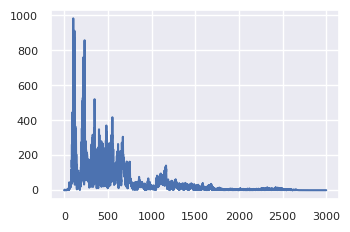

In [3]:
from scipy.fft import fft, ifft, fftfreq

signal = traces["clean_trace"][6]
signal = signal[~np.isnan(signal)]

N, T = len(signal), 1.0/SAMPLING_RATE

spectrum = np.abs(fft(signal)[:N//2])
freqs = fftfreq(N, T)[:N//2]

plt.plot(freqs, spectrum)

Audio split in 50 windows
Each window is 42.33 millisec long
Max frequency is 3.0 kHz
127


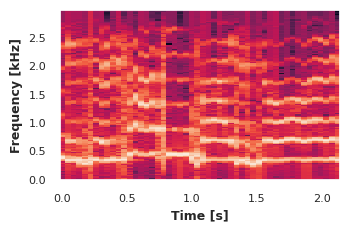

In [4]:
track_index = 1500
signal = traces["clean_trace"][track_index]
signal = signal[~np.isnan(signal)]

M, N, T = 50, len(signal), 1.0/SAMPLING_RATE

windows = np.array_split(signal, M)
winlen = np.min([len(w) for w in windows])

print(f"Audio split in {len(windows)} windows")
print(f"Each window is {winlen/SAMPLING_RATE*1e3:.2f} millisec long")
print(f"Max frequency is {np.max(freqs)*1e-3:.1f} kHz")

STFT = np.zeros((winlen//2, M))

for i, part in enumerate(windows):
    regularized_window = np.hamming(len(part))*part
    window_spectrum = np.abs(fft(regularized_window)[:winlen//2])**2
    STFT[:winlen//2, i] = np.log(window_spectrum/np.sum(window_spectrum))
    
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]*1e-3
print(winlen//2)
TT, FF = np.meshgrid(TT, FF)    
plt.pcolormesh(TT.T, FF.T, STFT.T)

plt.grid(ls="")
# plt.axis("off")
plt.xlabel("Time [s]");
plt.ylabel("Frequency [kHz]");
# plt.title(f"{df.sex[track_index]} {df.vocal_channel[track_index]} STFT");
plt.savefig('../images/fourier_STFT.pdf')

## Spectral statistics timeseries

Since the stft returns a matrix (bad), It is possible to extract a statictical feature from the spectrum of each window, such as the spectral centroid

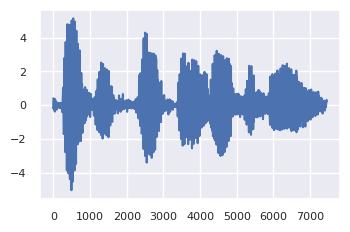

In [5]:
plt.plot(traces["clean_trace"][0])

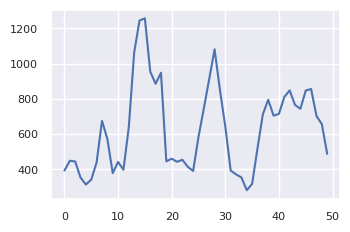

In [6]:
stft_centroid = np.zeros(M)
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]

for i in range(M):
    # get a distribution from STFT
    energy_density = np.exp(STFT[:, i]) - np.min(np.exp(STFT[:, i])) # offsets the minimum to be zero
    energy_density /= np.sum(energy_density)         # normalizes
#     plt.plot(FF, energy_density)

    # gets weighted mean
    stft_centroid[i] = np.sum(FF*energy_density)
    
plt.plot(stft_centroid)

## For the full dataset

Since the tracks have different length, the fourier coefficients have different length.
What is possible to do is to bin the spectrum in a range of freqs and then sum the squares (mean energy).

In [7]:
# def bin_spectral_energy(spectrum_energy, n_bins, max_freq, sampling_rate=SAMPLING_RATE, plot_check=False):
#     if len(spectrum_energy) < n_bins:
#         raise ValueError(f"too few frequencies to bin (spectrum has {len(spectrum_energy)})")
    
#     T = 1.0/sampling_rate
    
#     # Removes higher-pitch part that makes bins unequal
#     ss = spectrum_energy[:len(spectrum_energy) - (len(spectrum_energy)%n_bins) ]
#     ffs = fftfreq(2*len(ss), T)[:len(ss)]

#     ff_bin_edges = np.linspace(0, max_freq, n_bins + 1, endpoint=True)
    
#     binned_energies = np.zeros(n_bins)
#     for i in range(n_bins):
#         binned_energies[i] = np.mean(ss[(ffs >= ff_bin_edges[i])&(ffs < ff_bin_edges[i+1])] )
    
#     if plot_check:
#         plt.plot(ffs, ss, ls="", marker=".", ms=3,alpha=0.5, label=f"trace length = {2*len(ss)}")
#         plt.step(ff_bin_edges[:-1],binned_energies, where="post")
#         plt.yscale("log")
#         plt.xlabel("Frequency [Hz]")
#     return binned_energies

# # Test track
# fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
# test_track_index = 1500
# signal = traces["clean_trace"][test_track_index]
# signal = signal[~np.isnan(signal)]

# part = np.array_split(signal, 23)[0]
# regularized_window = np.hamming(len(part))*part
# window_spectrum = np.abs(fft(regularized_window)[:len(part)//2])**2
# print(len(part))
# u = np.log(bin_spectral_energy(window_spectrum, 45, 3000, plot_check=True))

# # Comparison
# # test_track_index = 1800
# # signal = traces["clean_trace"][test_track_index]
# # signal = signal[~np.isnan(signal)]

# # part = np.array_split(signal, 23)[0]
# # regularized_window = np.hamming(len(part))*part
# # window_spectrum = np.abs(fft(regularized_window)[:len(part)//2])**2
# # print(len(part))
# # u = np.log(bin_spectral_energy(window_spectrum, 45, 3000, plot_check=True))

# # plt.gcf().legend()
# plt.savefig("../images/fourier_binning.pdf")

In [8]:
from djanloo_fourier import STFTransformer

transf = STFTransformer()
transf.fit_transform(traces["clean_trace"])

/home/djanloo/Desktop/DM2/TimeSeries/djanloo_fourier.py:63: UserWarning: time bins/spectral bins not specified, setting balanced bins
  warnings.warn("time bins/spectral bins not specified, setting balanced bins")


shortest trace has length 5976


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [03:54<00:00, 10.45it/s]


(array([[[-9.19983850e+00,  4.46529221e-01,  1.94413155e+00, ...,
          -4.72409449e+00, -3.17990993e+00, -4.22690311e+00],
         [-2.99839743e+00, -6.77448665e-01,  2.22110146e+00, ...,
          -3.47149224e+00, -2.29998326e+00, -1.75629997e+00],
         [ 1.82322194e-01, -1.11480060e+00,  5.15815926e+00, ...,
           3.11229827e-01, -1.62144676e+00,  1.45471892e+00],
         ...,
         [-6.81121641e+00,  3.46240540e+00,  5.20361258e+00, ...,
          -8.14257207e+00, -9.58109691e+00, -6.62506196e+00],
         [-2.95594087e+00,  3.05463006e+00,  4.53829139e+00, ...,
          -6.86110493e+00, -1.08507223e+01, -6.61249297e+00],
         [-3.53333072e+00,  1.90621168e+00,  3.75860788e+00, ...,
          -8.04406574e+00, -1.53693749e+01, -9.35728337e+00]],
 
        [[-1.16130735e+00,  8.94894391e-01,  5.38020203e+00, ...,
          -5.37693993e-01, -3.79661838e+00, -4.09646662e+00],
         [-5.53725041e-01, -2.01619935e+00,  5.63125134e+00, ...,
          -2.54835362

In [9]:
transf.report(traces["clean_trace"])

Time bins = 54, Spectral bins = 54
min length of window is roughly 558
max number of Fourier coeffs is 279


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


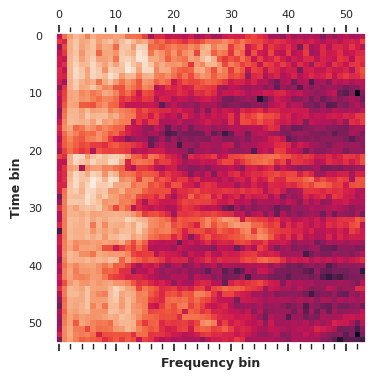

In [10]:
one_curve = transf.STFT[2]
plt.matshow(one_curve)
plt.grid(ls="")
plt.ylabel("Time bin")
plt.xlabel("Frequency bin");

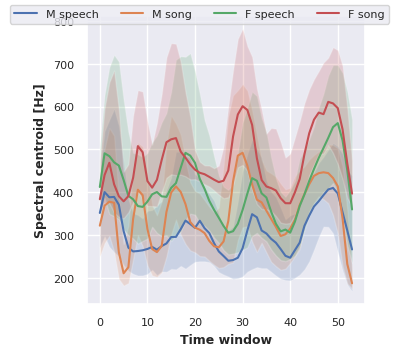

In [11]:
fig, ax = plt.subplots(figsize=default_style.HALFSIZE_FIGURE)
for s in ["M", "F"]:
    for vc in ["speech","song"]:
        subsamp = transf.spectral_centroid[(df.vocal_channel == vc)&(df.sex==s)]
        low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)
        
        plt.plot(mid, label=f"{s} {vc}")
        plt.fill_between(range(transf.n_time_bins), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="upper center")
plt.ylabel("Spectral centroid [Hz]")
plt.xlabel("Time window");
fig.tight_layout()

NameError: name 'N_TIME_BINS' is not defined

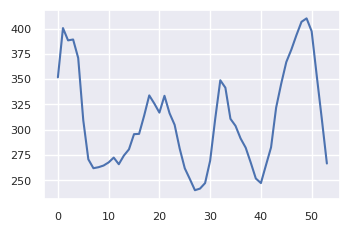

In [12]:
fig, ax = plt.subplots()
for s in ["M", "F"]:
    for vc in ["speech","song"]:
        subsamp = transf.spectral_mode[(df.vocal_channel == vc)&(df.sex==s)]
        low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)
        
        plt.plot(mid, label=f"{s} {vc}")
        plt.fill_between(range(N_TIME_BINS), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

In [ ]:
fig, ax = plt.subplots()
for s in ["M"]:
    for vc in ["speech"]:
        for emo in np.unique(df[(df.sex==s)&(df.vocal_channel == vc)].emotion):
        
            subsamp = transf.spectral_centroid[(df.vocal_channel == vc)&(df.sex==s)&(df.emotion==emo)]
            low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)

            plt.plot(mid, label=f"{s} {vc} {emo}")
            plt.fill_between(range(N_TIME_BINS), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

In [ ]:
np.save(os.path.join(TS_PREPROC_FOLDER, f"full_stft.npy"), transf.STFT)
np.save(os.path.join(TS_PREPROC_FOLDER, f"spectral_centroid.npy"), transf.spectral_centroid)
np.save(os.path.join(TS_PREPROC_FOLDER, f"spectral_mode.npy"), transf.spectral_mode)

## Check umap on spectral centroids

In [ ]:
from umap import UMAP

In [ ]:
X = transf.spectral_centroid

reducer = UMAP(n_neighbors=10)
embedding = reducer.fit_transform(X)

In [ ]:
plt.scatter(*embedding.T, s=5, c=(df.emotion=="calm")|(df.emotion=="sad")|(df.emotion=="fearful"), cmap="viridis")

## Test to see the evolution in fourier space

In [ ]:
X = transf.STFT

# Merges all tracks together
# In this way UMAP learns the manifold of spectral vectors
# independently from the track
X = X.reshape(-1,transf.n_spectral_bins)

print(X.shape)

In [ ]:
reducer = UMAP(n_neighbors=10)

N_SUBSAMP = 10_000
shuffled_subsamp = np.arange(len(X))
np.random.shuffle(shuffled_subsamp)
shuffled_subsamp = shuffled_subsamp[:N_SUBSAMP]

all_spectral_coeff = reducer.fit_transform(X[shuffled_subsamp])

In [ ]:
fig, ax =plt.subplots(figsize=default_style.FULLSIZE_FIGURE)
# colors = np.repeat(df.statement == "kids", N_TIME_BINS).values[shuffled_subsamp]
colors = np.tile(range(transf.n_time_bins), len(df))[shuffled_subsamp]
plt.scatter(*all_spectral_coeff.T, s=1, alpha=1, c= colors, cmap="viridis")

In [ ]:
from sklearn.manifold import Isomap
reducer = Isomap(n_neighbors=10)

all_spectral_coeff = reducer.fit_transform(X[shuffled_subsamp])

In [ ]:
fig, ax =plt.subplots(figsize=default_style.FULLSIZE_FIGURE)
colors = np.repeat(df.vocal_channel == "song", transf.n_time_bins).values[shuffled_subsamp]
plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.8, c= colors, cmap="viridis")

In [ ]:
# Now returns to treat each track as a timeseries of points in spectral space
X = X.reshape(-1, transf.n_time_bins, transf.n_spectral_bins)

# Predicts the path in 2D that corresponds to a trace
embedding = reducer.transform(X[1500])

In [ ]:
plt.plot(*embedding.T, color="k", lw=1)
plt.scatter(*embedding.T, c=range(N_TIME_BINS), zorder=2)
plt.colorbar()

plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.3, c= colors, cmap="viridis")

In [ ]:
colors = np.tile(range(transf.n_t), len(df))[shuffled_subsamp]
plt.plot(*embedding.T, color="k", lw=1)
plt.scatter(*embedding.T, c=range(N_TIME_BINS), zorder=2)
plt.colorbar()

plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.3, c= colors, cmap="viridis")

In [ ]:
from djanloo_fourier import STFTransformer

transf = STFTransformer(n_time_bins=None, 
                        n_spectral_bins=None, 
                        max_frequency=3000, 
                        sampling_rate=SAMPLING_RATE)

# Makes a square STFT
transf.balance_n_coeff(traces["clean_trace"])
transf.report(traces["clean_trace"])
STFT, sc = transf.fit_transform(traces["clean_trace"])